## Data Assimilation of Incompressible (Divergence-free) Kolmogorov Flows

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('..')

import flax
from flax.training import checkpoints
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import orbax.checkpoint as ocp
import seaborn as sns

import dps
from losses import get_constraint_losses_fn
from losses import get_divergence_fn
import model_utils as namm_mutils
import pdes

from score_flow import losses as score_losses
from score_flow import utils
from score_flow.models import utils as score_mutils
from score_flow.models import ddpm, ncsnpp, ncsnv2

from configs import namm_config as namm_config_provider
from configs import score_config as score_config_provider

sns.set(font_scale=2)
sns.set_style('ticks')
palette = sns.color_palette('colorblind')

2025-02-07 14:54:07.733682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738968847.747241  388083 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738968847.751592  388083 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
n_samples = 32
sample_rng = jax.random.PRNGKey(100)
_, sample_rngs = utils.psplit(sample_rng)
cmap = sns.cm.icefire

# The checkpoints of the models used for the paper were 
# saved with legacy Flax checkpointing instead of
# Orbax checkpointing.
use_orbax_checkpointing = False

finetune = True
if finetune:
  dm_epoch = 2000
  ft_epoch = 500
  mdm_epoch = 700
else:
  dm_epoch = 2000
  namm_epoch = 100
  mdm_epoch = 1500

workdir = '../checkpoints/Kolmogorov_incompress/sparseicnn_cyc=1.0_reg=0.001_constr=1.0_maxsig=0.5_lr=1e-03_bs=16_layers=2_fwdnfilt=32_bwdnfilt=64_nores'
dm_workdir = '../score_checkpoints/Kolmogorov_128x256_ncsnpp_nf=64_vpsde_betamin=0.1_betamax=20.0'

## Load NAMM

In [3]:
# NAMM config:
namm_config = namm_config_provider.get_config()
namm_config.data.dataset = 'Kolmogorov'
namm_config.data.height = 128
namm_config.data.width = 256
namm_config.data.num_channels = 2
namm_config.constraint.type = 'incompress'
namm_config.model.bwd_activation = 'none'
namm_config.model.bwd_residual = False
namm_config.model.fwd_icnn_n_layers = 2

image_shape = (namm_config.data.height, namm_config.data.width, namm_config.data.num_channels)
shape = (n_samples // jax.local_device_count(), *image_shape)

# Constraint distance function:
constr_losses_fn = get_constraint_losses_fn(namm_config)

vorticity_fn = pdes.get_vorticity_image_fn(vmap=False)

In [4]:
# Get NAMM model.
namm_model = namm_mutils.get_model(namm_config)
namm_state = namm_mutils.init_state(namm_config, namm_model)
namm_state, _, _ = namm_mutils.init_optimizer(namm_config, namm_state)

# Restore NAMM checkpoint.
if finetune:
  namm_ckpt_path = os.path.join(os.getcwd(), workdir, 'finetune/namm/checkpoints')
  namm_epoch = ft_epoch
else:
  namm_ckpt_path = os.path.join(os.getcwd(), workdir, 'namm/checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(namm_ckpt_path)
  namm_state = ckpt_mgr.restore(namm_epoch, args=ocp.args.StandardRestore(namm_state))
else:
  namm_state = checkpoints.restore_checkpoint(
    os.path.join(namm_ckpt_path, f'checkpoint_{namm_epoch}'),
    namm_state)
assert namm_state.epoch == namm_epoch
print(f'NAMM epoch: {namm_state.epoch}')

@jax.jit
def inverse_mirror_fn(x):
  return namm_model.backward(
    {'dropout': jax.random.PRNGKey(0)}, namm_state.bwd_params, x, train=False)

2025-02-07 14:54:19.139167: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-02-07 14:54:19.332061: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-02-07 14:54:20.327303: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-02-07 14:54:20.638980: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


NAMM epoch: 500


## Load MDM

In [5]:
score_config = score_config_provider.get_config()
score_config.data = namm_config.data
score_config.constraint = namm_config.constraint

# Initialize score model.
score_model, score_init_model_state, score_init_params = score_mutils.init_model(
  jax.random.PRNGKey(0), score_config)
score_tx = score_losses.get_optimizer(score_config)
score_opt_state = score_tx.init(score_init_params)
score_state = score_mutils.State(
  step=0,
  epoch=0,
  model_state=score_init_model_state,
  opt_state=score_opt_state,
  ema_rate=score_config.model.ema_rate,
  params=score_init_params,
  params_ema=score_init_params,
  rng=jax.random.PRNGKey(0))

# Restore MDM checkpoint.
mdm_ckpt_path = os.path.join(os.getcwd(), workdir, f'mdm/checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(mdm_ckpt_path)
  score_state = ckpt_mgr.restore(mdm_epoch, args=ocp.args.StandardRestore(score_state))
else:
  score_state = checkpoints.restore_checkpoint(
    os.path.join(mdm_ckpt_path, f'checkpoint_{mdm_epoch}'),
    score_state)
assert score_state.epoch == mdm_epoch
print('MDM epoch:', score_state.epoch)

score_pstate = flax.jax_utils.replicate(score_state)

sde, t0 = utils.get_sde(score_config)

# Get score function.
score_fn = score_mutils.get_score_fn(
    sde,
    score_model,
    score_state.params_ema,
    score_state.model_state,
    train=False,
    continuous=True)

2025-02-07 14:54:50.585622: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng39{k2=7,k12=1,k13=0,k14=4,k15=0,k17=1,k18=0,k23=0} for conv %cudnn-conv.1 = (f32[2048,1,128,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[2048,1,131,259]{3,2,1,0} %bitcast.23, f32[1,1,4,4]{3,2,1,0} %bitcast.27), window={size=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_name="jit(conv_general_dilated)/jit(main)/conv_general_dilated" source_file="/scratch/imaging/projects/constrained_priors/release/notebooks/../score_flow/models/up_or_down_sampling.py" source_line=280}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-02-07 14:54:51.041027: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.455554252s
Trying algorithm eng39{k2

MDM epoch: 700


## Forward model

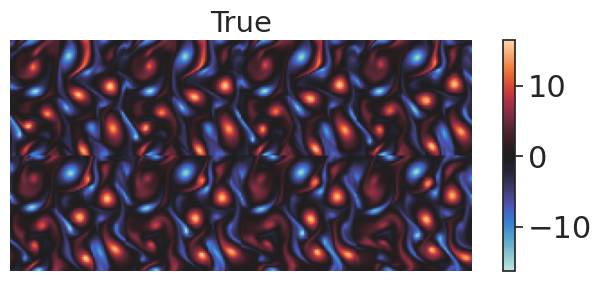

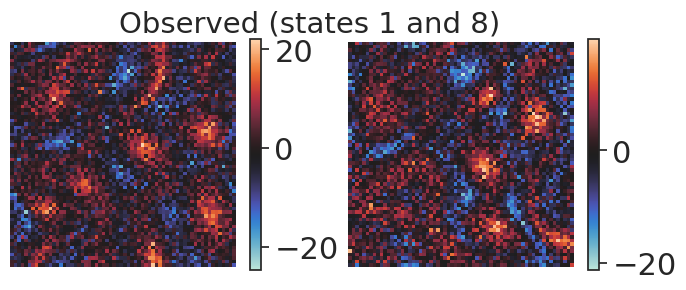

In [6]:
n_per_row = 4
size = namm_config.data.width // n_per_row

def forward_model(x):
  state0 = x[:, :size, :size, :]
  stateT = x[:, -size:, -size:, :]
  # Concatenate two observed states into one image.
  return jnp.concatenate((state0, stateT), axis=2)

sigma = 0.2  # measurement noise
def get_measurement(rng, x):
  y_clean = forward_model(x)
  y_noisy = y_clean + jax.random.normal(rng, y_clean.shape) * sigma
  return y_noisy

X_test = np.load('../data/kolmogorov_test_set.npy')
x_true = X_test[0]

meas_rng = jax.random.PRNGKey(0)
y = get_measurement(meas_rng, x_true[None, ...])[0]
y_w = vorticity_fn(y)
x_true_w = vorticity_fn(x_true)

fig = plt.figure(figsize=(8, 3))
plt.imshow(x_true_w, cmap=cmap); plt.axis('off')
plt.colorbar()
plt.title('True', fontsize=21)
plt.show()

fig = plt.figure(figsize=(8, 3))
fig.suptitle('Observed (states 1 and 8)', fontsize=21)
plt.subplot(121)
plt.imshow(y_w[:size, :size], cmap=cmap); plt.axis('off')
plt.colorbar()
plt.subplot(122)
plt.imshow(y_w[-size:, -size:], cmap=cmap); plt.axis('off')
plt.colorbar()
plt.show()

## Mirror DPS

In [7]:
mirror_dps_sampler = dps.get_mirror_dps_sampler(
  y, forward_model, sigma, sde, score_fn,
  inverse_mirror_fn, shape, eps=t0)

In [8]:
scale = 0.05
%time y_samples = jax.device_get(mirror_dps_sampler(sample_rngs, scale))
samples = inverse_mirror_fn(y_samples)
samples = samples.reshape(n_samples, *image_shape)

# Convert to vorticity.
w_samples = jax.vmap(vorticity_fn)(samples)

CPU times: user 3min 33s, sys: 4min 8s, total: 7min 42s
Wall time: 2min 22s


## Vanilla DPS

In [9]:
# Restore DM checkpoint.
dm_ckpt_path = os.path.join(os.getcwd(), dm_workdir, 'checkpoints')
if use_orbax_checkpointing:
  ckpt_mgr = ocp.CheckpointManager(dm_ckpt_path)
  dm_score_state = ckpt_mgr.restore(dm_epoch, args=ocp.args.StandardRestore(score_state))
else:
  dm_score_state = checkpoints.restore_checkpoint(
    os.path.join(dm_ckpt_path, f'checkpoint_{dm_epoch}'),
    score_state)
assert dm_score_state.epoch == dm_epoch
print(f'DM epoch: {dm_score_state.epoch}')

# Get score function.
dm_score_fn = score_mutils.get_score_fn(
    sde,
    score_model,
    dm_score_state.params_ema,
    dm_score_state.model_state,
    train=False,
    continuous=True)

# Get DPS sampler.
dps_sampler = dps.get_dps_sampler(
  y, forward_model, sigma, sde, dm_score_fn, shape,
  eps=t0)

DM epoch: 2000


In [10]:
scale = 0.05
%time dps_samples = jax.device_get(dps_sampler(sample_rngs, scale))
dps_samples = dps_samples.reshape(n_samples, *image_shape)

# Filter out any samples that have NaNs.
dps_samples = dps.get_valid_samples(dps_samples)
print(f'{len(dps_samples)}/{n_samples} valid samples')

# Convert to vorticity.
dps_w_samples = jax.vmap(vorticity_fn)(dps_samples)

CPU times: user 2min 10s, sys: 3min 31s, total: 5min 42s
Wall time: 1min 39s
32/32 valid samples


## Constraint-guided DPS (CG-DPS)

In [11]:
cgdps_sampler = dps.get_dps_sampler(
  y, forward_model, sigma, sde, dm_score_fn, shape,
  constraint_weight=200, constraint_losses_fn=constr_losses_fn,
  eps=t0)

In [12]:
scale = 0.05
%time cgdps_samples = jax.device_get(cgdps_sampler(sample_rngs, scale))
cgdps_samples = cgdps_samples.reshape(n_samples, *image_shape)

# Filter out any samples that have NaNs.
cgdps_samples = dps.get_valid_samples(cgdps_samples)
print(f'{len(cgdps_samples)}/{n_samples} valid samples')

# Convert to vorticity.
cgdps_w_samples = jax.vmap(vorticity_fn)(cgdps_samples)

CPU times: user 2min 13s, sys: 3min 30s, total: 5min 43s
Wall time: 1min 39s
32/32 valid samples


## Evaluate results

### Compare constraint distances of estimated samples

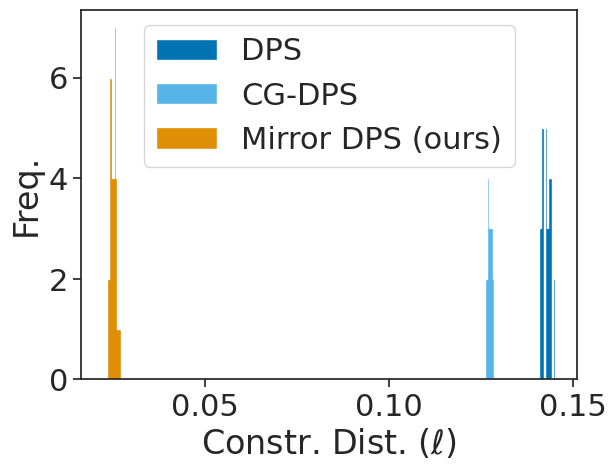

In [13]:
constr_losses = constr_losses_fn(samples)
dps_constr_losses = constr_losses_fn(dps_samples)
cgdps_constr_losses = constr_losses_fn(cgdps_samples)

plt.hist(dps_constr_losses, histtype='stepfilled', color=palette[0], label='DPS')
plt.hist(cgdps_constr_losses, histtype='stepfilled', color=palette[9], label='CG-DPS')
plt.hist(constr_losses, histtype='stepfilled', color=palette[1], label='Mirror DPS (ours)')
plt.legend()
plt.xlabel(r'Constr. Dist. ($\ell$)')
plt.ylabel('Freq.')
plt.show()

### Compare constraint residuals of estimated samples

In [14]:
# Get a function that gives us the residual from the divergence-free constraint.
div_fn = get_divergence_fn(nt=8, n_per_row=n_per_row)
def residual_fn(x):
  div = div_fn(x)  # (b, nt, h, w)
  # Ignore boundary.
  div = div.at[:, :, 0, :].set(0)
  div = div.at[:, :, :, 0].set(0)
  div = np.transpose(div, (0, 2, 3, 1))  # (b, h, w, nt)
  residual = jax.vmap(pdes.make_image_from_trajectory, in_axes=(0, None))(div, n_per_row)
  return residual

residuals = residual_fn(samples)
dps_residuals = residual_fn(dps_samples)
cgdps_residuals = residual_fn(cgdps_samples)

In [15]:
def trajectory_image_fn(image):
  """Turn `image`, of shape (h * n_rows, w * n_per_row, c), into an image
  of shape (h, w * nt, c) that shows the states side by side."""
  n_cols = image.shape[1] // size
  n_rows = image.shape[0] // size
  n_states = n_rows * n_cols
  trajectory_image = np.zeros((size, n_states * size, image.shape[2]))
  for i in range(n_states):
    row = i // n_cols
    col = i % n_cols
    trajectory_image[:, i * size:(i + 1) * size] = image[row * size:(row + 1) * size, col * size:(col + 1) * size]
  return trajectory_image

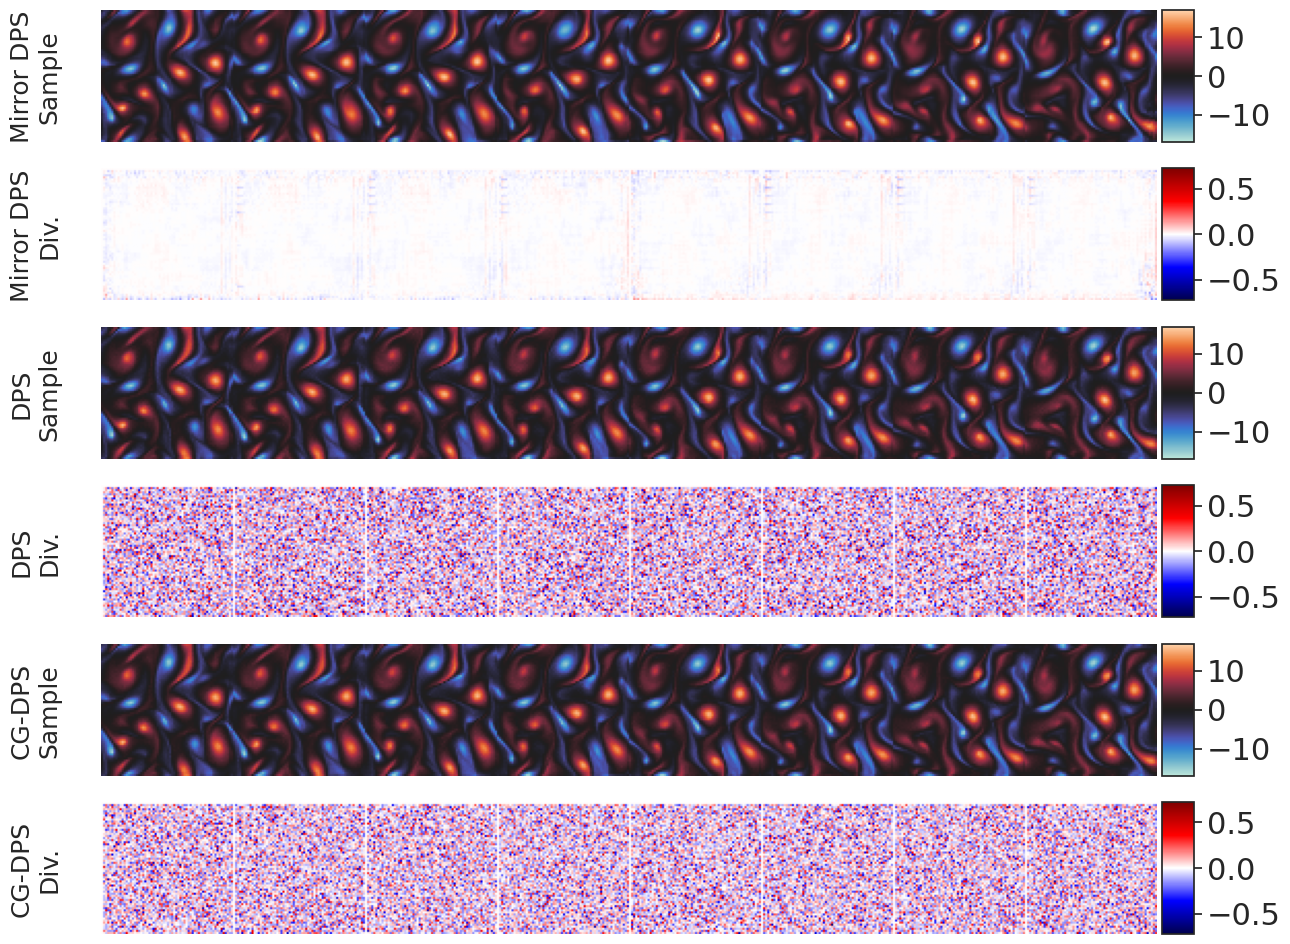

In [16]:
sample_idx = 0

fig, axs = plt.subplots(6, 1, figsize=(18, 12))

methods = ['Mirror DPS', 'DPS', 'CG-DPS']
sample_per_method = [w_samples[sample_idx], dps_w_samples[sample_idx], cgdps_w_samples[sample_idx]]
residual_per_method = [residuals[sample_idx], dps_residuals[sample_idx], cgdps_residuals[sample_idx]]
max_residual = np.max(np.abs(residual_per_method))
max_vorticity = np.max(np.abs(sample_per_method))

for i, image in enumerate(sample_per_method):
  ax = axs[2 * i]
  p = ax.imshow(trajectory_image_fn(image), clim=(-max_vorticity, max_vorticity), cmap=cmap)
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='3%', pad=0.05)
  fig.colorbar(p, cax=cax)
  ax.text(-0.5 * size, 0.5 * size, f'{methods[i]}\nSample', ha='center', va='center', rotation=90, fontsize=18)
for i, image in enumerate(residual_per_method):
  ax = axs[2 * i + 1]
  p = ax.imshow(trajectory_image_fn(image), clim=(-max_residual, max_residual), cmap='seismic')
  ax.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='3%', pad=0.05)
  fig.colorbar(p, cax=cax)
  ax.text(-0.5 * size, 0.5 * size, f'{methods[i]}\nDiv.', ha='center', va='center', rotation=90, fontsize=18)

plt.show()